In [1]:
from scipy.linalg import expm
#Importing constants
import scipy.constants as const
#Numpy
import numpy as np
import math
#Plotting
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from qiskit.visualization import plot_bloch_vector

In [2]:
# Functions Def

def alpha(state):
    return state[0][0]

def beta(state):
    return state[1][0]

def remove_global_phase(alpha, beta):
    # Let's find the phase of alpha and multiply alpha and beta by the conjugate to remove it
    # After removing global phase we take only the real part as the imag part of alpha is numerical noise
    phase_alpha = np.angle(complex(alpha))
    alpha = np.real(alpha*np.exp(-1j*phase_alpha))
    beta  = beta*np.exp(-1j*phase_alpha)

    return [alpha, beta]

def check_normalised(alpha, beta):
    prob_alpha = np.abs(alpha)**2
    prob_beta  = np.abs(beta)**2
    prob_sum   = prob_alpha + prob_beta

    return np.isclose(prob_sum, 1)

def angles_to_amplitudes(theta, phi):

    alpha = np.cos(theta/2)
    beta  = np.sin(theta/2)*np.exp(1j*phi)
    return [alpha, beta]

def amplitudes_to_angles(alpha, beta):
    # Remove global phase
    amplitudes = remove_global_phase(alpha, beta)

    theta = 2*np.arccos(alpha)
    phi   = np.angle(beta)

    return [theta, phi]

# Return the bloch vector for plotting on the bloch sphere
# Specify as type 'amplitudes' [alpha, beta] or 'angles' [theta, phi]
def find_bloch_vector(state_values, coeff_type='amplitudes'):

    # I flatten the input list if given as a column vector
    # We represent column vectors as a list of lists in numpy arrays for matrix-vector multiplication
    # The length of the shape of [1, 2, 3] is 1, the length of the shape [[1],[2],[3]] is 2
    if len(np.shape(state_values)) > 1:
        state_values = list(np.concatenate(state_values).flat)

    if(coeff_type == 'amplitudes'):
        amplitudes = remove_global_phase(state_values[0], state_values[1])
        angles     = amplitudes_to_angles(amplitudes[0], amplitudes[1]) #angles [theta, phi]
        # These are the projections from a 3D spherical coodinates vector to x,y,z coordinates
        bloch_x = np.sin(angles[0])*np.cos(angles[1])
        bloch_y = np.sin(angles[0])*np.sin(angles[1])
        bloch_z = np.cos(angles[0])
    elif(coeff_type == 'angles'):
        angles = state_values
        # These are the projections from a 3D spherical coodinates vector to x,y,z coordinates
        bloch_x = np.sin(angles[0])*np.cos(angles[1])
        bloch_y = np.sin(angles[0])*np.sin(angles[1])
        bloch_z = np.cos(angles[0])

    return [bloch_x, bloch_y, bloch_z]

## Question 1 

In [3]:
initial_state1 = np.array([[np.sqrt(3)/2],[1/2]])
initial_state2 = np.array([[1/7 - 1j*9/17],[np.sqrt(7302)/119+3/7*1j]])

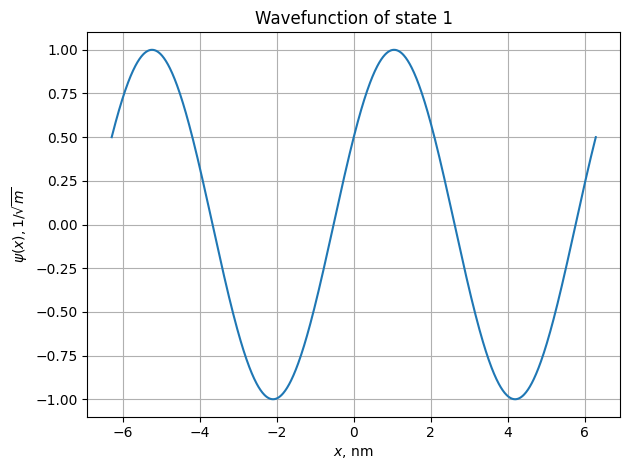

In [4]:
# Define the x-axis
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# Define the wavefunction
plt.plot(x, initial_state1[0][0]*np.sin(x) + initial_state1[1][0]*np.cos(x))
plt.xlabel("$x$, nm")
plt.ylabel("$\\psi(x), 1/\\sqrt{m}$")
plt.title('Wavefunction of state 1')
plt.grid()
plt.tight_layout()


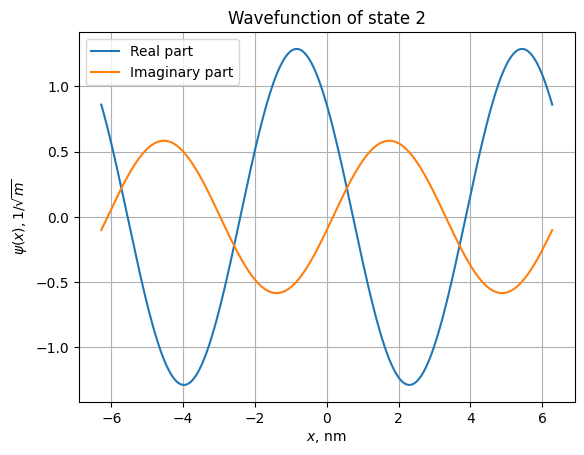

In [5]:
# Define the x-axis
x = np.linspace(-2*np.pi, 2*np.pi, 1000)

# Define the wavefunction
y = initial_state2[0][0] * np.exp(-1j * x) + initial_state2[1][0] * np.exp(1j * x)

plt.plot(x, y.real, label='Real part')
plt.plot(x, y.imag, label='Imaginary part')
plt.xlabel("$x$, nm")
plt.ylabel("$\\psi(x), 1/\\sqrt{m}$")
plt.title('Wavefunction of state 2')
plt.legend()
plt.grid()


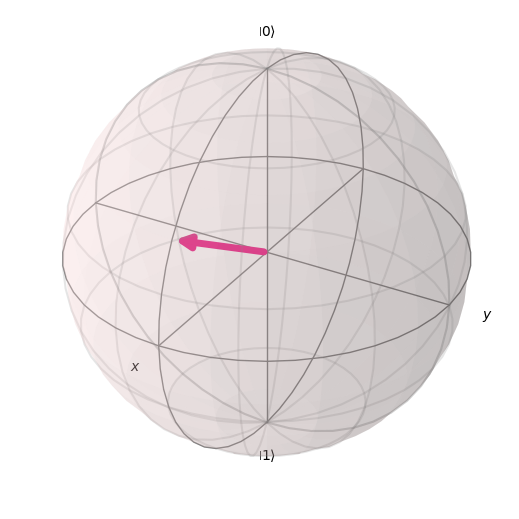

In [6]:
# State 1
alpha1 = alpha(initial_state1)
beta1 = beta(initial_state1)

bloch_vector = find_bloch_vector(initial_state1, coeff_type = 'amplitudes')
plot_bloch_vector(bloch_vector, coord_type='cartesian')

[0.5483474991958135, (-0.22669499599493945+0.8049375124297238j)]


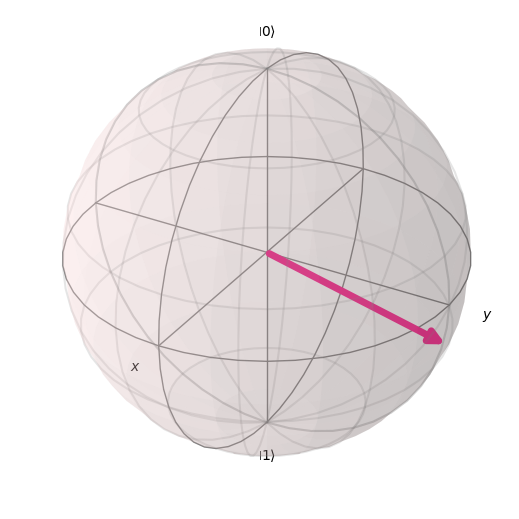

In [7]:
alpha2 = alpha(initial_state2)
beta2 = beta(initial_state2)

state = remove_global_phase(alpha2, beta2)
print(state)

bloch_vector = find_bloch_vector(state, coeff_type = 'amplitudes')
plot_bloch_vector(bloch_vector, coord_type='cartesian')

## Question 2

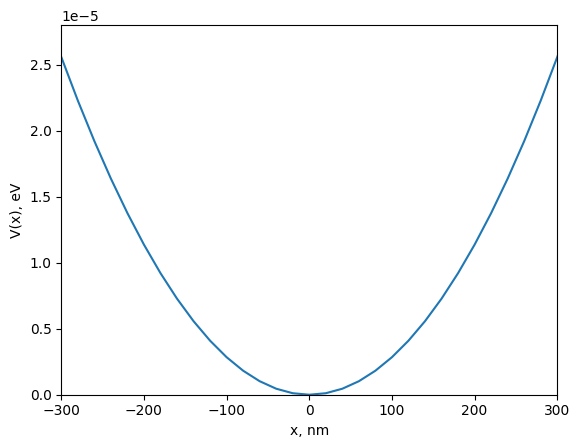

In [8]:
# Potential profile parameters:
# a [nm]
a_nm = 10000
# V0 [eV]
V0_eV = 1e-6
# Converting the constants to SI:
a = a_nm*1e-9
V0 = V0_eV*const.e
#V0_inf = 0 #10000.0*const.e

omega = 1e10
m_electron = const.m_e



# Potential profile:
def Vi(x):
  return (1/2)*m_electron*(omega**2)*(x**2)
  #return np.where(x<-a, V0_inf,
            #np.where((x>=-a)&(x<=a), (1/2)*m_electron*(omega**2)*(x**2), V0_inf))

#Number of points
N = 1001
# Creating the mesh of x points:
x = np.linspace(-1*a,1*a,N)
# Creating the potential profile V(x):
V = Vi(x)

# Plotting the potential profile:
fig1 = plt.figure()
ax1  = fig1.add_subplot(1,1,1)
ax1.plot(x*1e9,V/const.e)
ax1.set_ylim((0,28*V0/const.e))
ax1.set_xlim((-300,300))
ax1.set_xlabel("x, nm")
ax1.set_ylabel("V(x), eV")

# Building the matrix:
M = np.zeros((N-2,N-2))
for i in range(N-2):
  M[i][i] = const.hbar**2/(const.m_e*(x[1]-x[0])**2) + V[i+1]
  if(i!=0):
    M[i][i-1] = -const.hbar**2/(2.0*const.m_e*(x[1]-x[0])**2)
  if(i!=N-3):
    M[i][i+1] = -const.hbar**2/(2.0*const.m_e*(x[1]-x[0])**2)

# Obtaining the eigenvalues and eigenvectors:
from numpy.linalg import eig
eval, evec = eig(M)
# Transposing the evec matrix (because eigenfunctions are columns by default)
evec = np.transpose(evec)
# Sorting Eigenvalues and Eigenvectors:
idx = eval.argsort()
eval = eval[idx]
evec = evec[idx] #Still a valid eigenvector if need to multiply by minus 1

In [9]:
print(eval[0]/const.e, eval[1]/const.e)

3.283937299100221e-06 9.837504522821193e-06


Text(0, 0.5, 'Probability of |0> State')

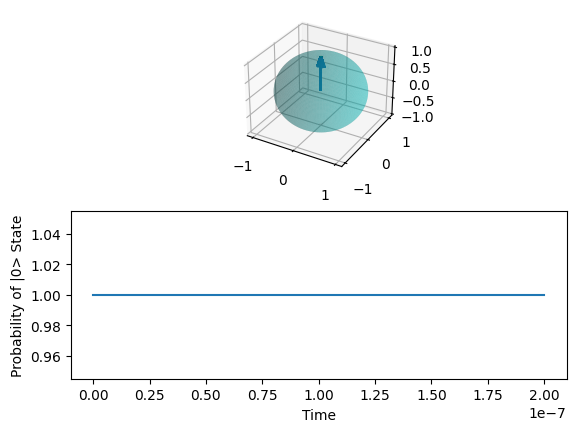

In [10]:
hamiltonian = np.array([[eval[0], 0 ],
                          [0, eval[1]]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0,200e-9,500)
initial_state = np.array([[1],[0]])

up_state = np.array([[1], [0]])
down_state = np.array([[0], [1]])

def prob_up(state):
  return np.abs(np.matmul(np.transpose(np.conjugate(up_state)), state)[0][0])**2

def prob_down(state): 
  return np.abs(np.matmul(np.transpose(np.conjugate(down_state)), state)[0][0])**2

# Create a sphere
r = 1
phi, theta = np.mgrid[0.0:np.pi:100j, 0.0:2.0*np.pi:100j]
x = r*np.sin(phi)*np.cos(theta)
y = r*np.sin(phi)*np.sin(theta)
z = r*np.cos(phi)

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

Text(0, 0.5, 'Probability of |0> State')

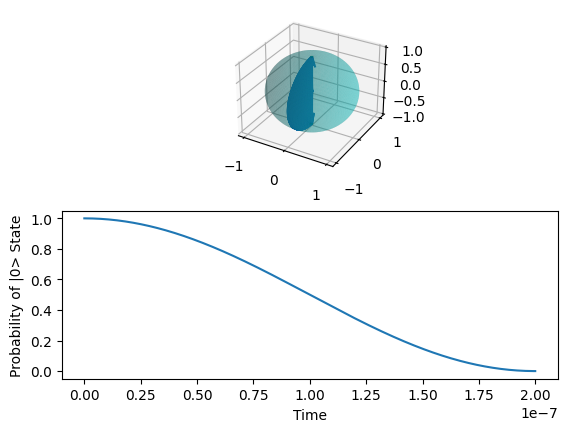

In [11]:
hamiltonian = np.array([[0, (const.hbar)*((eval[1]-eval[0])/2)+(const.hbar)*(np.pi/(400e-9)) ],
                          [(const.hbar)*(-(eval[1]-eval[0])/2)+(const.hbar)*(np.pi/(400e-9)), 0]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0,200e-9,500)
initial_state = np.array([[1],[0]])

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

Text(0, 0.5, 'Probability of |0> State')

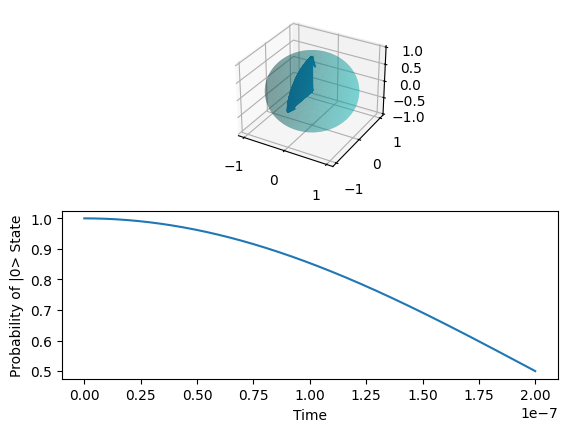

In [12]:
hamiltonian = np.array([[0, ((const.hbar)*((eval[1]-eval[0])/2)+(const.hbar)*(np.pi/(400e-9)))/2 ],
                          [((const.hbar)*(-(eval[1]-eval[0])/2)+(const.hbar)*(np.pi/(400e-9)))/2, 0]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0,200e-9,500)
initial_state = np.array([[1],[0]])

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

In [13]:
print(expm(-1j*hamiltonian/const.hbar))

[[1.+0.00000000e+00j 0.+2.20818919e-11j]
 [0.+2.20818919e-11j 1.+0.00000000e+00j]]


Text(0, 0.5, 'Probability of |0> State')

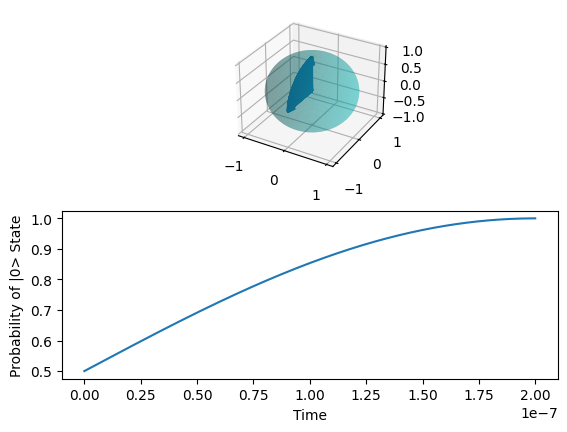

In [14]:
hamiltonian = np.array([[0, ((const.hbar)*((eval[1]-eval[0])/2)-(const.hbar)*(np.pi/(400e-9)))/2 ],
                          [((const.hbar)*((eval[1]-eval[0])/2)-(const.hbar)*(np.pi/(400e-9)))/2, 0]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0,200e-9,500)
initial_state = np.array([[1/(np.sqrt(2))],[-1j/(np.sqrt(2))]])

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

## Question 3

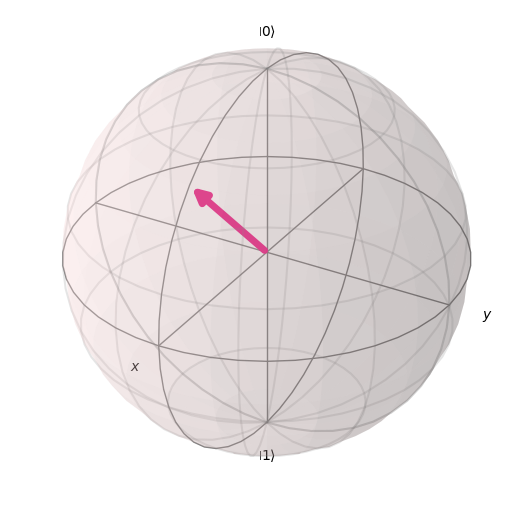

In [15]:
theta = np.pi/4
psi = 0

bloch_vector = find_bloch_vector([theta, psi], coeff_type = 'angles')
plot_bloch_vector(bloch_vector, coord_type='cartesian')

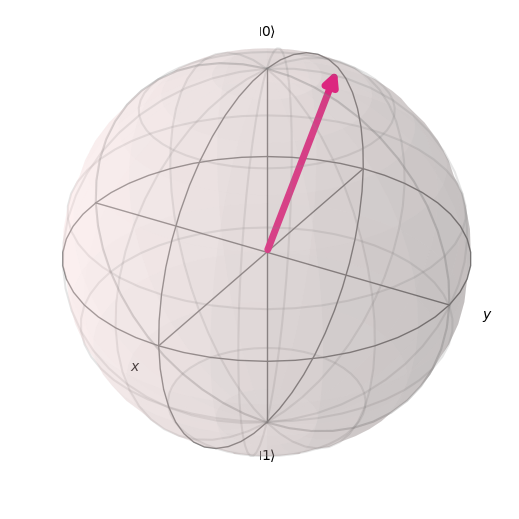

In [16]:
theta = (np.pi)/4
psi = np.pi

bloch_vector = find_bloch_vector([theta, psi], coeff_type = 'angles')
plot_bloch_vector(bloch_vector, coord_type='cartesian')

1.66332e-09
1.66666e-09


Text(0, 0.5, 'Probability of |0> State')

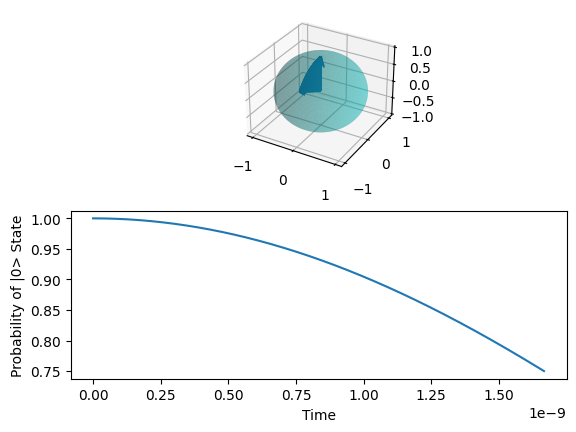

In [17]:
hamiltonian = np.array([[0, const.h*50e6 ],
                          [const.h*50e6, 0]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0, 1.66666e-9,500)
initial_state = np.array([[1],[0]])

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  if math.isclose(prob_up(current_state), 0.75, abs_tol = 0.001):
    print(current_time)
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

Text(0, 0.5, 'Probability of |0> State')

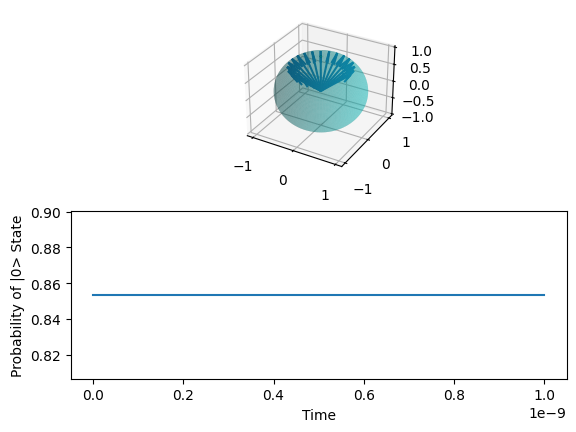

In [18]:
hamiltonian = np.array([[eval[0], 0 ],
                          [0, eval[1]]])

evolution_operator  = lambda time : expm(-1j*hamiltonian*time/const.hbar)

time = np.linspace(0, 1e-9,20)
initial_state = np.array([[np.cos(np.pi/8)],[0]])

#Set colours and render
fig_bloch = plt.figure()
ax_bloch = fig_bloch.add_subplot(211, projection='3d')
ax_prob = fig_bloch.add_subplot(212)
ax_bloch.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.3, linewidth=0)

prob_up_time = []

for current_time in time:
  current_state = np.matmul(evolution_operator(current_time),initial_state)
  prob_up_time.append(prob_up(current_state))
  if math.isclose(prob_up(current_state), 0.75, abs_tol = 0.001):
    print(current_time)
  theta = 2*np.arccos(np.abs(current_state[0]))
  phi   = np.angle(current_state[1]) - np.angle(current_state[0])
  if math.isclose(phi, np.pi, abs_tol = 0.01):
    print(current_time)
  ax_bloch.quiver(0, 0, 0, np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta))

ax_prob.plot(time, prob_up_time)
ax_prob.set_xlabel("Time")
ax_prob.set_ylabel("Probability of |0> State")

In [19]:
from qiskit import QuantumCircuit, transpile

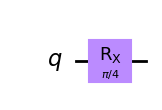

In [20]:
qc = QuantumCircuit(1)
qc.rx(np.pi/4, 0)
qc = transpile(qc, basis_gates=['rx', 'ry'])

qc.draw('mpl')


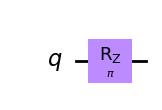

In [25]:

qc = QuantumCircuit(1)
qc.rz(np.pi, 0)
qc.draw('mpl')


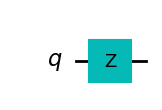

In [26]:
qc = QuantumCircuit(1)
qc.z(0)
qc.draw('mpl')